This notebook walks the user through building a video2vision operator to convert the linearized camera values to animal sensory impressions. It uses the FReD database of flower reflectances. Due to license issues, we cannot include this database in the electronic supplemental material, but it is available from the original source:

http://www.reflectance.co.uk/

In [1]:
import json

import matplotlib.pyplot as plot
import numpy as np
from tabulate import tabulate
import video2vision as v2v

# Path to file containing sensitivities of the camera.
CAMERA_SENSE_PATH = '../data/camera_sensitivities.csv'
# Path to file containing sensitivities of the organism's photoreceptors.
ANIMAL_SENSE_PATH = '../data/animal_sensitivities/avian_sensitivities.csv'
# Path to a large bank of material reflectances, used to calculate the conversion
# coefficients from the camera image to the animal image.
REFLECTIVITY_PATH = '../data/material_reflectances.csv'
# Path to write the converter to.
OUT_PATH = '../data/converters/avian_converter.json'

The converter is a simple linear map:
$$
\mbox{animal}_i = \sum_j M_{ij} \mbox{camera}_j
$$
We calculate the linear map by fitting it to the FReD database of flower reflectances:

In [2]:
# Load camera sensitivities
camera_sense = np.genfromtxt(CAMERA_SENSE_PATH, skip_header=True, delimiter=',')[:, 1:]
# Load animal sensitivities
animal_sense = np.genfromtxt(ANIMAL_SENSE_PATH, skip_header=True, delimiter=',')[:, 1:]
# Load material reflectivities
reflectivities = np.genfromtxt(REFLECTIVITY_PATH, skip_header=True, delimiter=',')[:, 1:]
if reflectivities.max() > 2:
    reflectivities /= 100
ref_train, ref_test = reflectivities[:, :-250], reflectivities[:, -250:]

sense_converter = v2v.LinearMap.build_sensor_convertor(
    ref_train, camera_sense, animal_sense
)

Let's visualize the sensitivities of the camera and the animal:

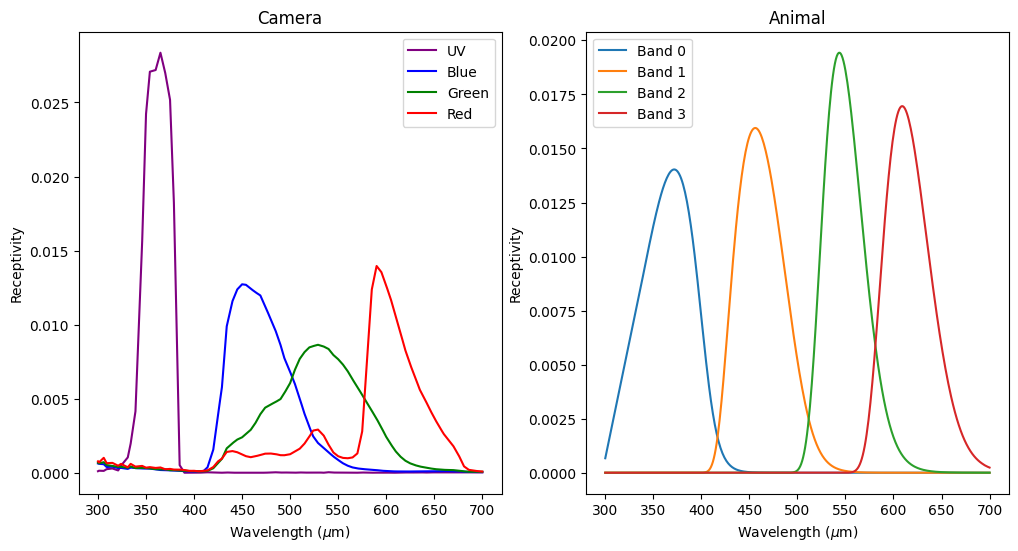

In [3]:
plot.figure(figsize=(12, 6))

plot.subplot(1, 2, 1)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.plot(
        np.arange(300, 701),
        camera_sense[:, band],
        color=color,
        label=band_name,
    )
plot.xlabel('Wavelength ($\mu$m)')
plot.ylabel('Receptivity')
plot.title('Camera')
plot.legend()

plot.subplot(1, 2, 2)
for band in range(animal_sense.shape[1]):
    plot.plot(
        np.arange(300, 701),
        animal_sense[:, band],
        label=f'Band {band}',
    )
plot.xlabel('Wavelength ($\mu$m)')
plot.ylabel('Receptivity')
plot.title('Animal')
plot.legend()

plot.show()

And let's estimate the error of the conversion on a withheld set of 250 reflectances:

In [4]:
pred_camera_values = ref_test.T.dot(camera_sense)
pred_animal_values = ref_test.T.dot(animal_sense)
converted_camera_values = pred_camera_values.dot(sense_converter.mat)

r2s = []
for band in range(animal_sense.shape[1]):
    ss_res = ((pred_animal_values[:, band] - converted_camera_values[:, band])**2).sum()
    ss_tot = ((pred_animal_values[:, band] - pred_animal_values[:, band].mean())**2).sum()
    mae = np.abs(pred_animal_values[:, band] - converted_camera_values[:, band]).mean()
    r2s.append((band, mae, 1 - (ss_res / ss_tot)))

print(tabulate(r2s, headers=['Band', 'MAE', 'R2']))

  Band         MAE        R2
------  ----------  --------
     0  0.00533859  0.983028
     1  0.0016481   0.999766
     2  0.00591206  0.997446
     3  0.00436196  0.998843


And save the converter:

In [5]:
with open(OUT_PATH, 'w') as out_file:
    json.dump(sense_converter._to_json(), out_file)